In [1]:
!pip install torchvision opencv-python colorama

You are using pip version 18.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import cv2
import time
import colorama

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [20, 10]

import torch
import torchvision
import torchvision.transforms as transforms

### Loading and normalizing CIFAR10

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

Files already downloaded and verified
Files already downloaded and verified


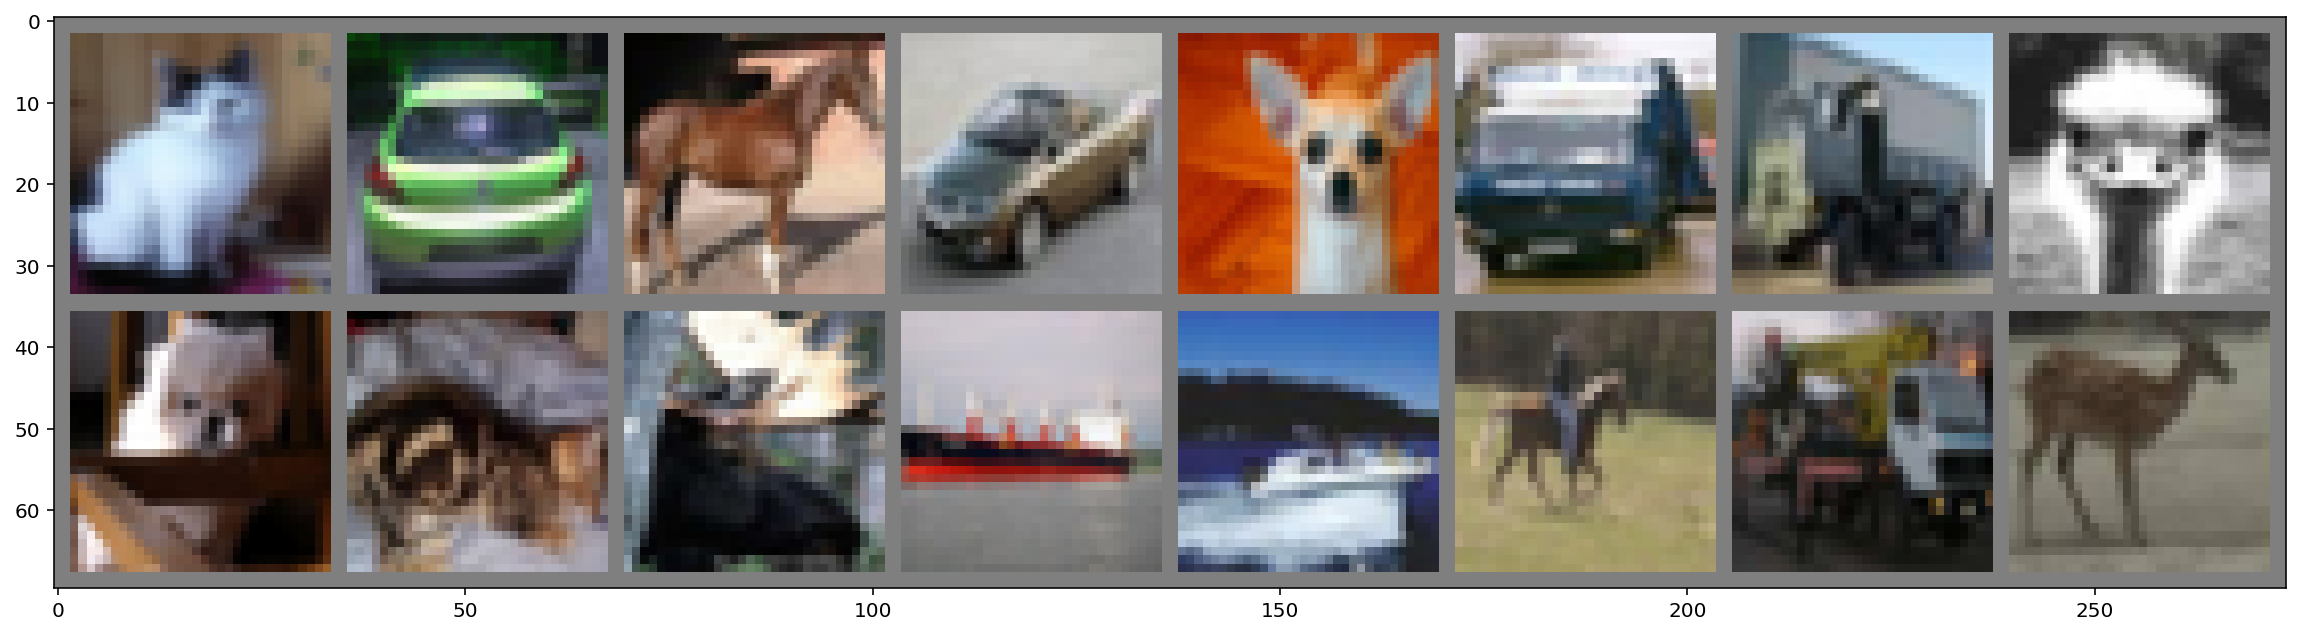

  cat   car horse   car   dog truck truck  bird   dog   cat  deer  ship  ship horse truck  deer


In [4]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

<https://pytorch.org/docs/stable/nn.html#conv2d>

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### Print a network summary

In [6]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Retrieve trainable parameters

In [7]:
named_params = list(net.named_parameters())
print("len(params): %s\n" % len(named_params))
for name, param in named_params:
    print("%s:\t%s" % (name, param.shape))

len(params): 10

conv1.weight:	torch.Size([6, 3, 5, 5])
conv1.bias:	torch.Size([6])
conv2.weight:	torch.Size([16, 6, 5, 5])
conv2.bias:	torch.Size([16])
fc1.weight:	torch.Size([120, 400])
fc1.bias:	torch.Size([120])
fc2.weight:	torch.Size([84, 120])
fc2.bias:	torch.Size([84])
fc3.weight:	torch.Size([10, 84])
fc3.bias:	torch.Size([10])


### Feed network with a random input

In [8]:
input = torch.randn(1, 3, 32, 32)  # batch_size, num_channels, height, width
out = net(input)
print("Log-Probabilities: \n%s\n" % out)
print("Probabilities: \n%s\n" % torch.exp(out))
print("out.shape: \n%s" % (out.shape,))

Log-Probabilities: 
tensor([[ 0.0412, -0.0490, -0.0114, -0.0662, -0.0910, -0.1040, -0.0224, -0.0751,
         -0.0951, -0.0733]], grad_fn=<AddmmBackward>)

Probabilities: 
tensor([[1.0421, 0.9522, 0.9887, 0.9359, 0.9130, 0.9012, 0.9778, 0.9277, 0.9093,
         0.9294]], grad_fn=<ExpBackward>)

out.shape: 
torch.Size([1, 10])


### How can we now actually train our CNN?

In [9]:
def train_cnn(model, train_loader, test_loader, device, num_epochs=2, lr=0.1):
    model.train()
    model = model.to(device)
    # define an optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        print("="*40, "Starting epoch %d" % (epoch + 1), "="*40)
        
        model.train()  # reset to train mode after accuracy computation
                
        # dataloader returns batches of images for 'data' and a tensor with their respective labels in 'labels'
        for batch_idx, (data, labels) in enumerate(train_loader):
            data, labels = data.to(device), labels.to(device)

            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            
            if batch_idx % 315 == 0:
                print("Batch %d/%d, Loss=%.4f" % (batch_idx, len(train_loader), loss.item()))

        train_acc = accuracy(model, train_loader, device)
        test_acc = accuracy(model, test_loader, device)
        print(colorama.Fore.GREEN, "\nAccuracy on training: %.2f%%" % (100*train_acc))
        print("Accuracy on test: %.2f%%" % (100*test_acc), colorama.Fore.RESET)

### Evaluate model's accuracy on train/test data

In [10]:
def accuracy(model, dataloader, device):
    """ Computes the model's accuracy on the data provided by 'dataloader'
    """
    model.eval()
    
    num_correct = 0
    num_samples = 0
    with torch.no_grad():  # deactivates autograd, reduces memory usage and speeds up computations
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)

            predictions = model(data).max(1)[1]  # indices of the maxima along the second dimension
            num_correct += (predictions == labels).sum().item()
            num_samples += predictions.shape[0]
        
    return num_correct / num_samples

### Start the training!

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
net = net.to(device)

train_cnn(net, train_loader, test_loader, device, lr=2e-3)

======================================== Starting epoch 1 ========================================
Batch 0/3125, Loss=2.3043
Batch 315/3125, Loss=1.8615
Batch 630/3125, Loss=1.6291
Batch 945/3125, Loss=1.5385
Batch 1260/3125, Loss=1.4528
Batch 1575/3125, Loss=1.4762
Batch 1890/3125, Loss=1.4051
Batch 2205/3125, Loss=1.1837
Batch 2520/3125, Loss=1.4397
Batch 2835/3125, Loss=1.2829
 
Accuracy on training: 47.77%
Accuracy on test: 46.82% 
======================================== Starting epoch 2 ========================================
Batch 0/3125, Loss=1.2749
Batch 315/3125, Loss=1.0653
Batch 630/3125, Loss=1.7718
Batch 945/3125, Loss=1.7799
Batch 1260/3125, Loss=1.2906
Batch 1575/3125, Loss=1.1438
Batch 1890/3125, Loss=1.4904
Batch 2205/3125, Loss=1.1884
Batch 2520/3125, Loss=1.4773
Batch 2835/3125, Loss=1.3003
 
Accuracy on training: 54.03%
Accuracy on test: 52.55% 


### Let's look at some of the model's predictions

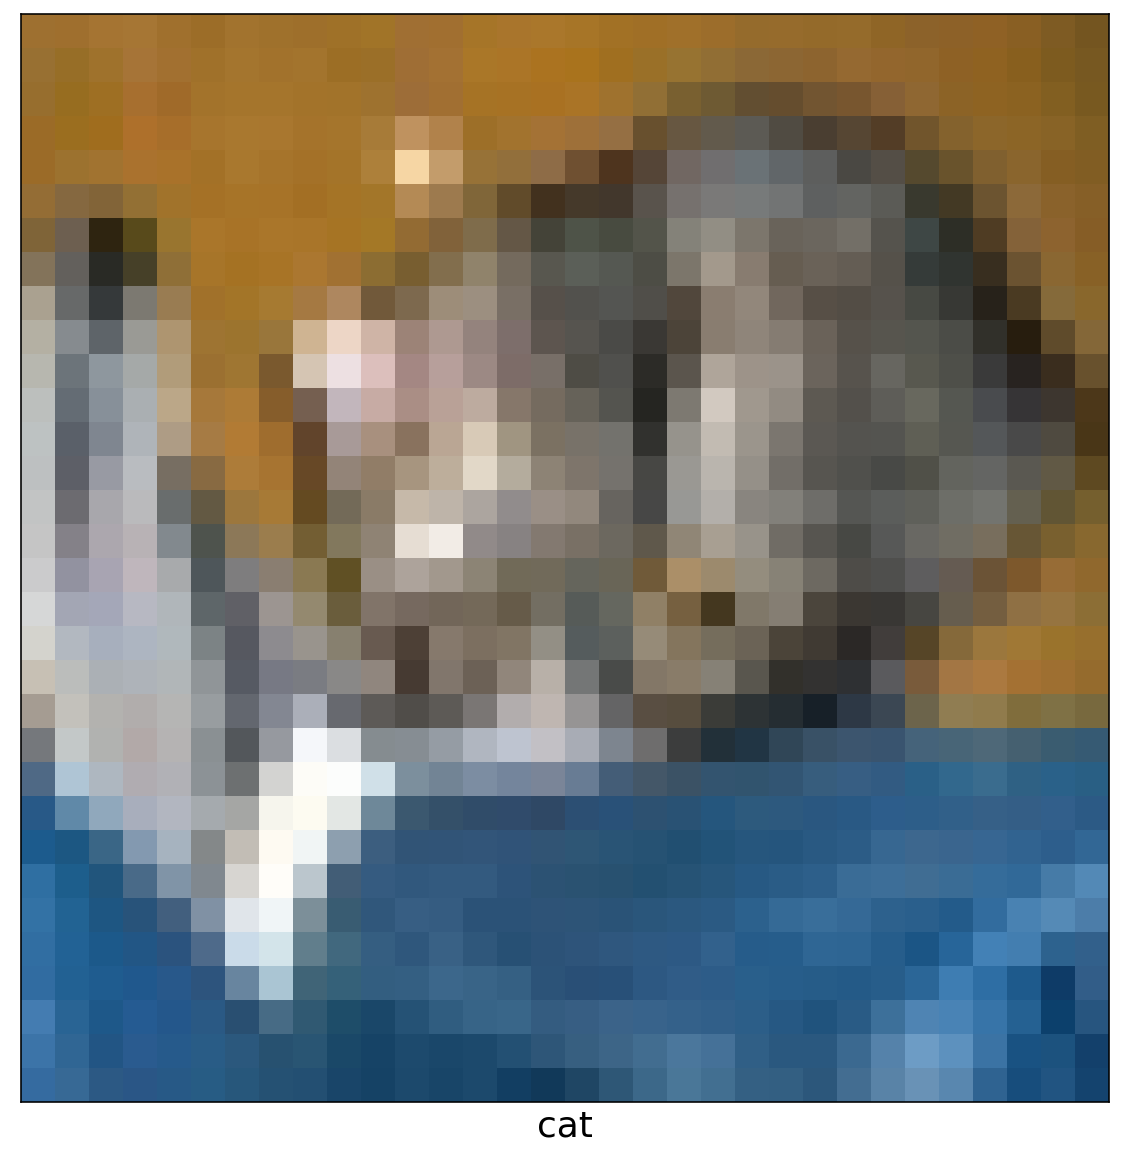

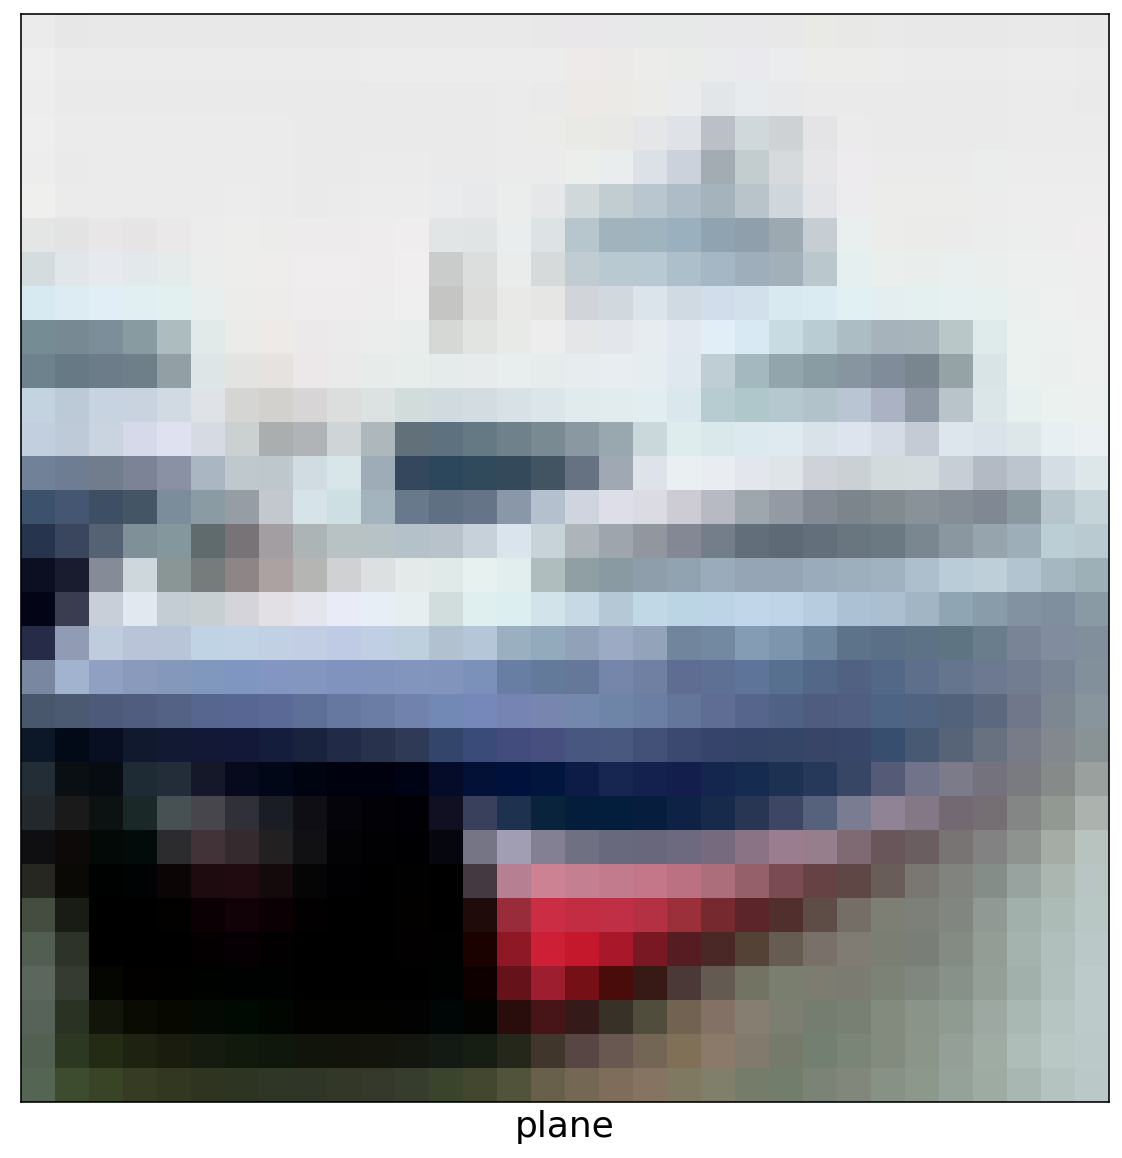

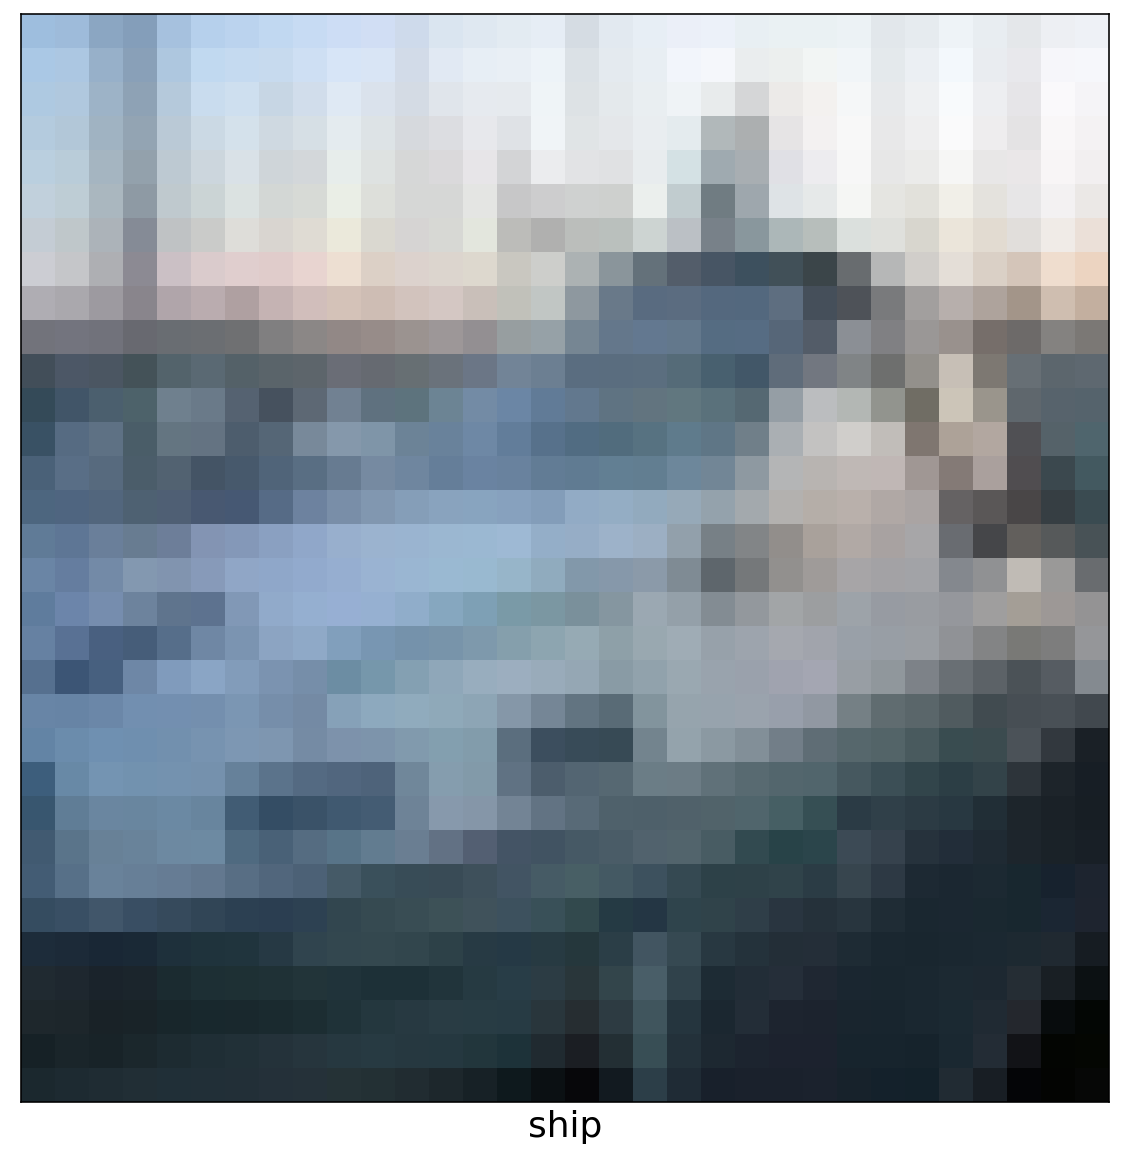

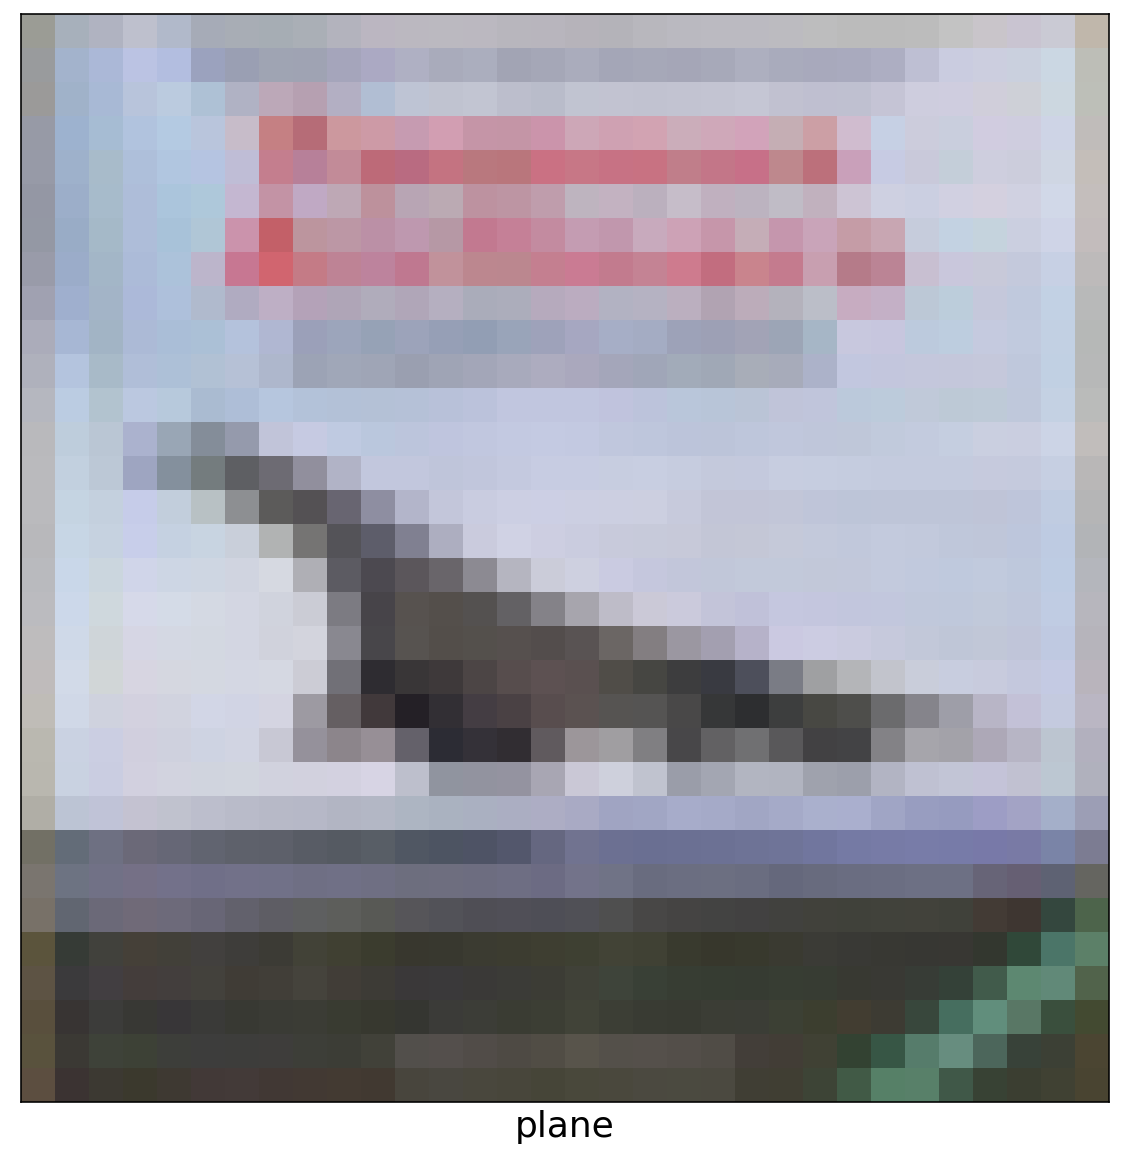

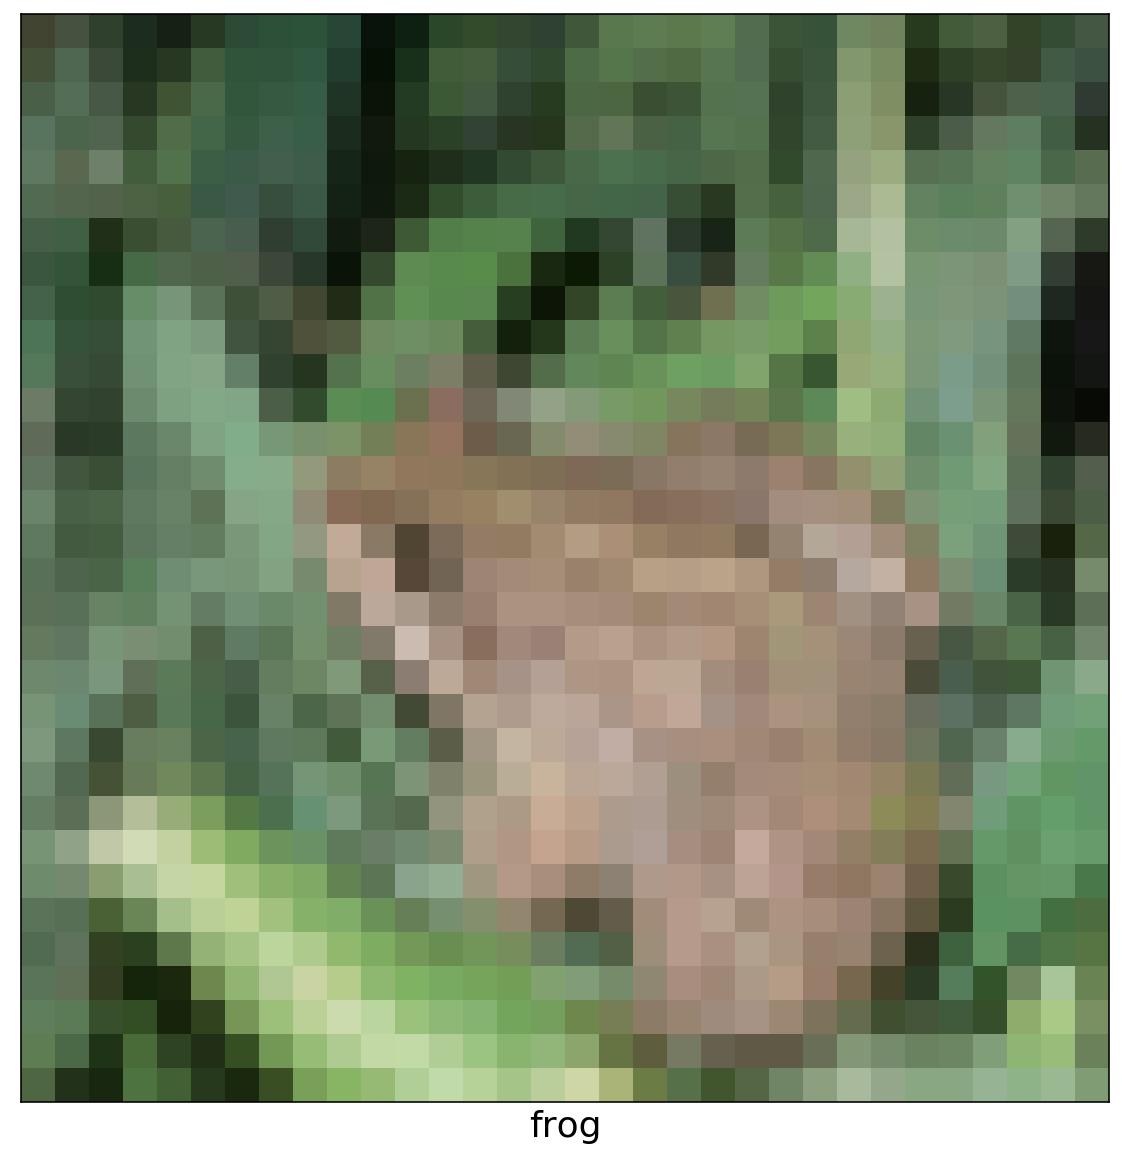

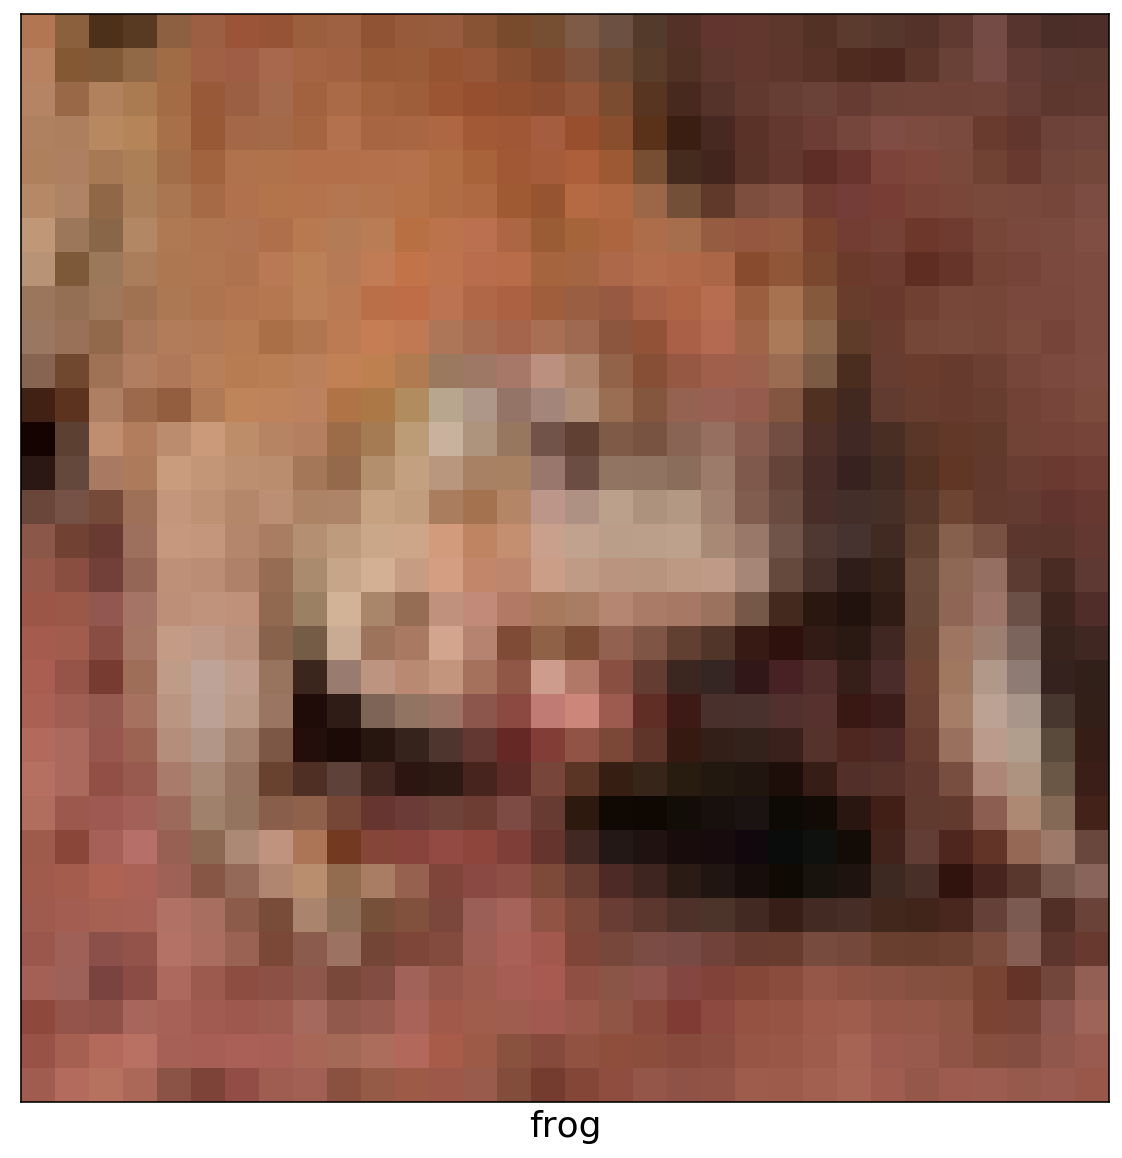

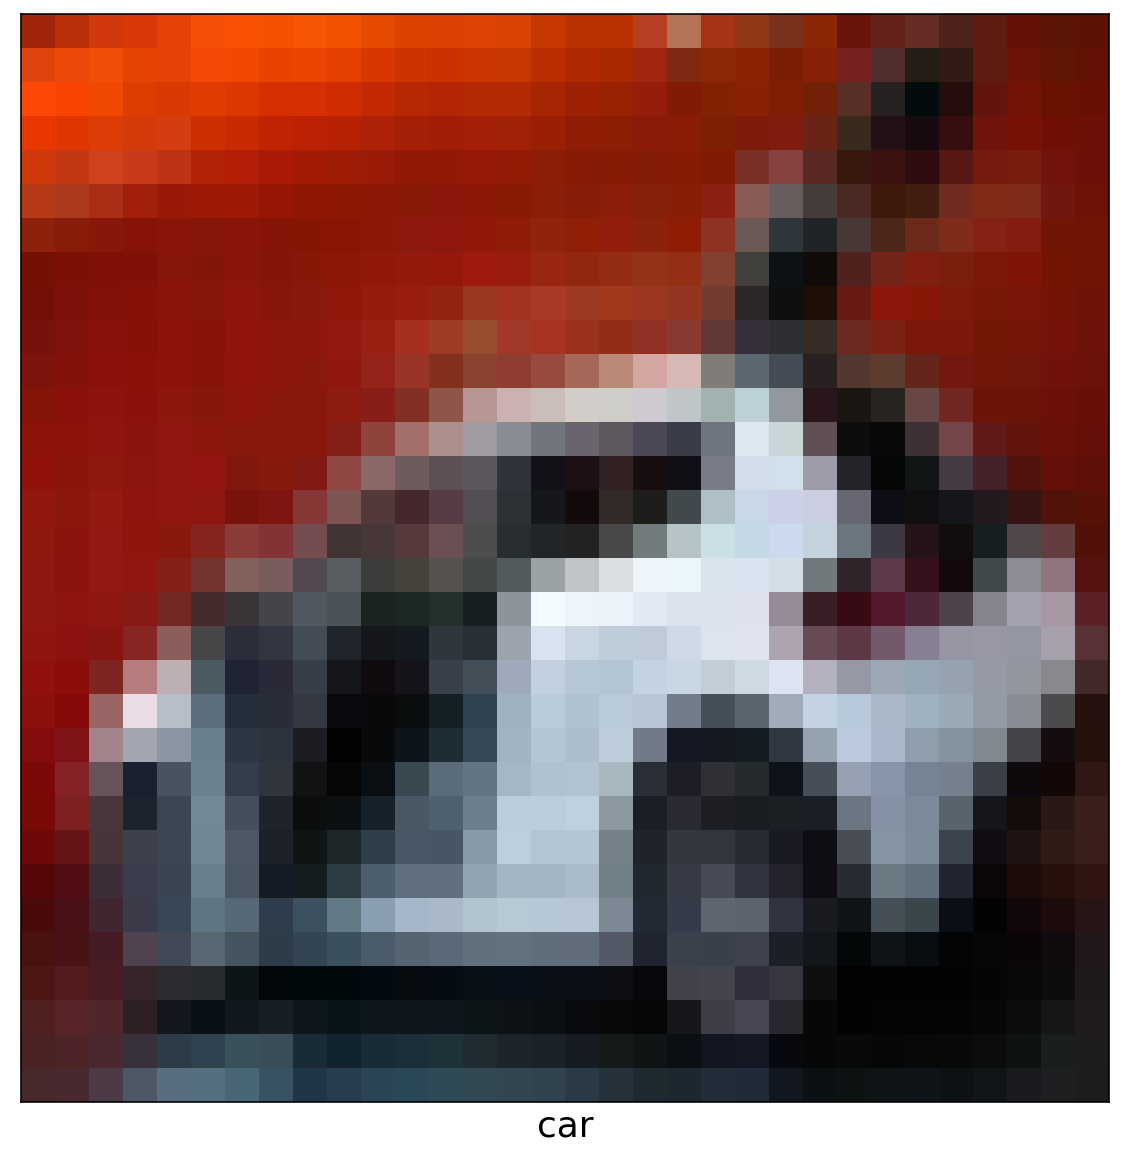

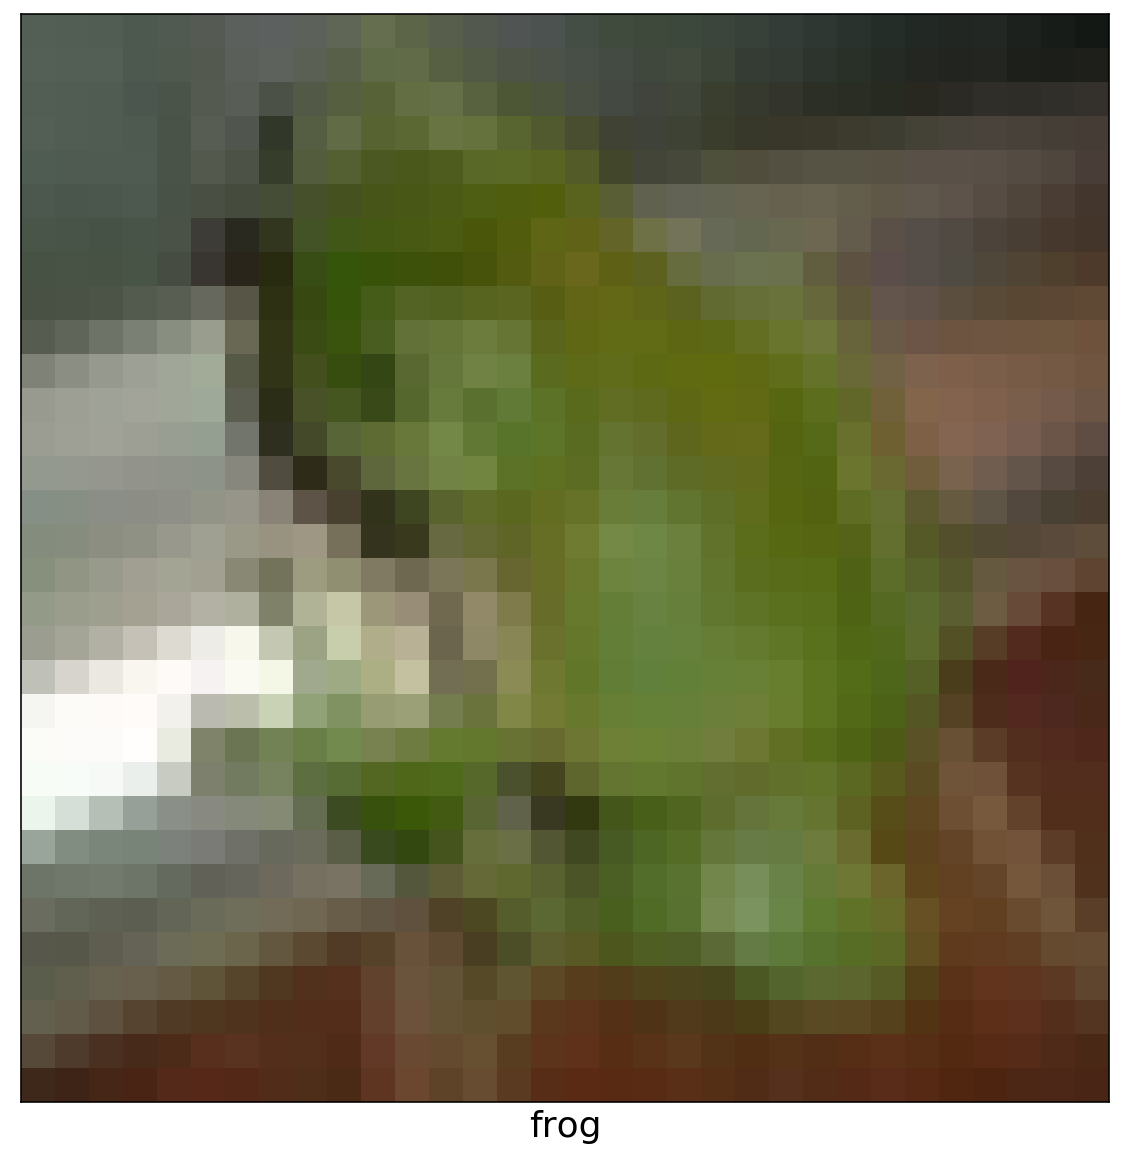

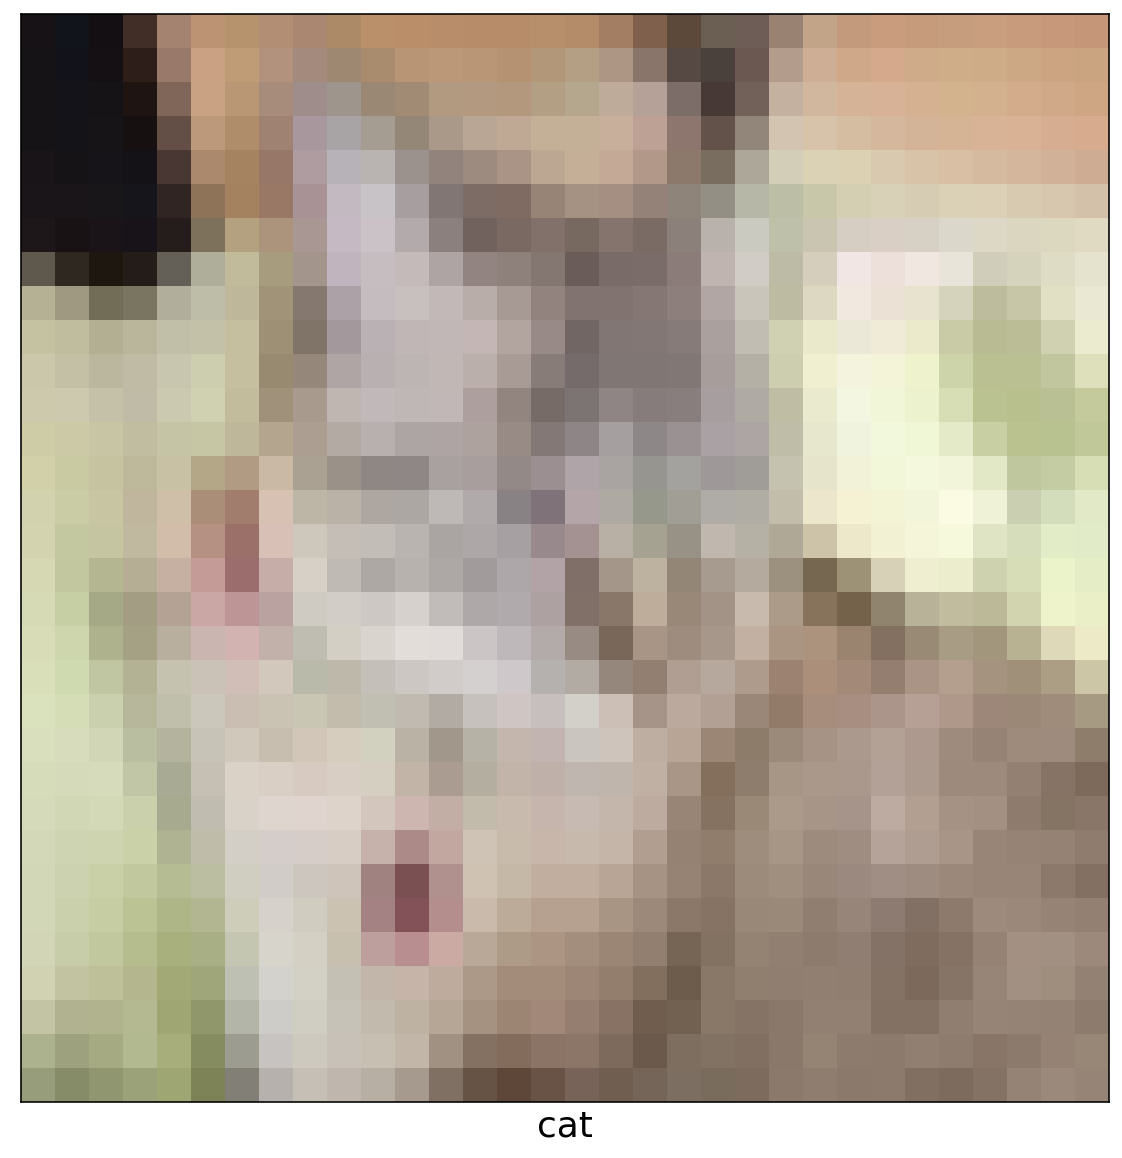

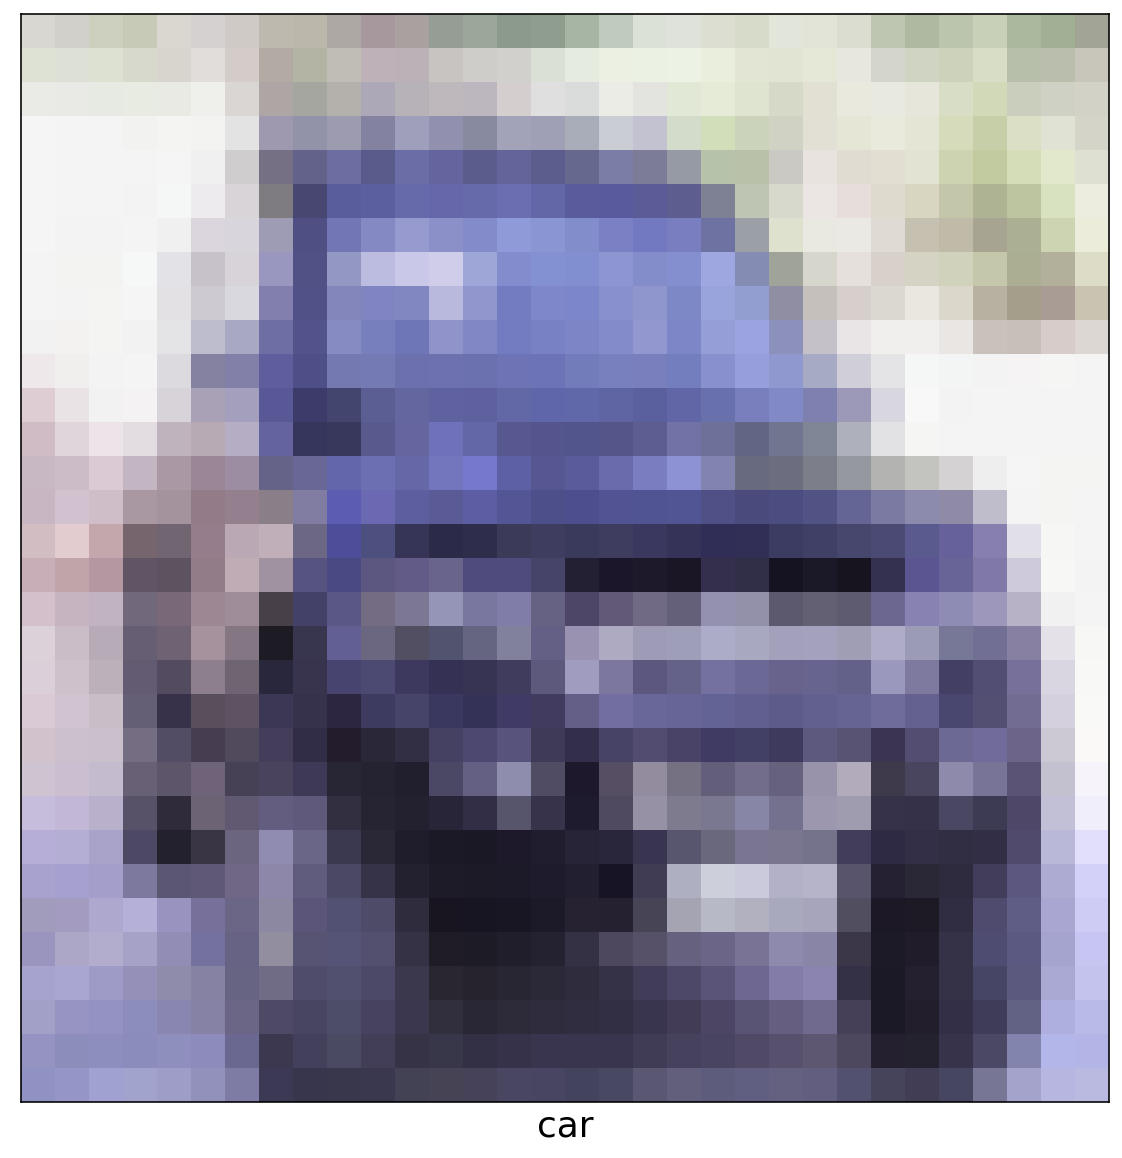

In [13]:
def visualize_predictions(model, dataloader, device):
    data, labels = next(iter(dataloader))
    data, labels = data[:10].to(device), labels[:10]
    predictions = model(data).max(1)[1]
    
    predictions, data = predictions.cpu(), data.cpu()
    
    for i in range(10):
        img = data.squeeze(1)[i]
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

        plt.xlabel(classes[predictions[i].item()], fontsize=18)
        plt.xticks([])
        plt.yticks([])    
        plt.show()
visualize_predictions(net, test_loader, device)

# Exercise: Create your own version of VGG11

VGG has 2 different parts: backbone and classifier

An image of the architecture:
https://i.imgur.com/uLXrKxe.jpg

Some usefull documentation:
* https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential
* https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d
* https://pytorch.org/docs/stable/nn.html#torch.nn.ReLU
* https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout
  


In [14]:
# VGG11 model from torchvision

import torchvision.models as models
net_to_implement = models.vgg11()
net_to_implement

# input size of the first conv layer should be 1 instead of 3!

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class VGG11(nn.Module):

    def __init__(self, backbone, classifier):
        super().__init__()   
        self.backbone = backbone
        self.adaptativeAveragePool = nn.AdaptiveAvgPool2d(output_size=(7,7))
        self.classifier = classifier
        
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.adaptativeAveragePool(x)
        x = x.view(x.size(0), -1) #flatten the image 
        x = self.classifier(x)
        return x

In [16]:
def get_backbone():
    return nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1, stride=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=(2), stride=2),
        
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, stride=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=(2), stride=2),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, stride=1),
        nn.ReLU(True),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1, stride=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=(2), stride=2),

        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1, stride=1),
        nn.ReLU(True),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, stride=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=(2), stride=2),
        
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, stride=1),
        nn.ReLU(True),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, stride=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=(2), stride=2)
        
    )

In [17]:
def get_classifier(num_classes):
    return nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, num_classes),
    )

In [18]:
# instantiate and print your Net
net = VGG11(get_backbone(), get_classifier(num_classes))
net

VGG11(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [ ]:
# Train the model
train_cnn(net, train_loader, test_loader, device)

======================================== Starting epoch 1 ========================================
Batch 0/3125, Loss=2.3057
Batch 315/3125, Loss=2.3164
Batch 630/3125, Loss=2.2934
Batch 945/3125, Loss=2.3809
Batch 1260/3125, Loss=2.3710
Batch 1575/3125, Loss=2.2870
Batch 1890/3125, Loss=2.2906
Batch 2205/3125, Loss=2.3673
Batch 2520/3125, Loss=2.3097
Batch 2835/3125, Loss=2.3612
 
Accuracy on training: 10.00%
Accuracy on test: 10.00% 
======================================== Starting epoch 2 ========================================
Batch 0/3125, Loss=2.4454
Batch 315/3125, Loss=2.2888
Batch 630/3125, Loss=2.2876
Batch 945/3125, Loss=2.3278
